# Wind Energy Production Forecasting

- Wind energy production/amount is a function of _wind speed_ and its _direction_.
 - forecast amount will sold to the grid operator
 - the grid operator fines if there's shortfall from forecast
 - excess is wasted
- Grid operator **(buys , 10 euro cents/kWh)**, enforces fines if there's a shortfall by the energy producer
- Spot market price for energy **(sells, 20 euro cents)**

__Objective__
- Our goal is to get a _T+18 hour energy forecast_ , _every hour_ . Our objective, as a trader, is to maximize profits for our client using our energy production forecast and the given trading algorithm (this alg-m is fixed for simplicity).


## Trade:
1. Produce a forecast
    - Excess is wasted (i.e. 0cents/kWh)
    - Shortfall is covered by trader (we need to buy this amount from spot market, _if we have cash in hand_ ):
        - buy 20cents/kWh
    - If there's no money to buy:
        - If _cash in hand_ is lower than required to purchase the shortfall amount
        - We are fined by grid 100cents/kWh
        - Recorded as a negative value (debt), and it's cumulative.
1. Starting budget 10,000,000 cents
1. Need to return 10,000,000 cents at the end of the evaluation period.
1. The remainder is our client's profits. Our objective is to maximise this profit.

## Datasets and Sources
Datasets:
1. Wind Energy Production \[src : Réseau de transport d'électricité [(RTE)](https://www.rte-france.com/), the French electricity transmission system operator\]
    - **We average and standardise to a time base of 1 hour** a near-realtime wind energy data from RTE's online database.
    - The dataset is called `energy-ile-de-france` (contains the consolidated energy wind production for the Ile-de-France region surrounding Paris)
2. Wind Forecasts \[src : [Terra Weather](http://www.terra-weather.com)\]
    - Provided are _wind forecasts for 8 locations_ of major wind farms in the Ile-de-France region.



### Wind Energy Production Data
- The provided data is __from 01 Jan 2017 to the present__.
- [`https://www.rte-france.com/en/eco2mix/eco2mix-telechargement-en`](https://www.rte-france.com/en/eco2mix/eco2mix-telechargement-en)
- The energy production values are in __MWh__ units (we need to convert them to kWh before trading!).
- The dataset is called `energy-ile-de-france`, and contains _standardised 1 hourly values_.

Following are for downloading regional energy production _raw data for Ile-de-France_ :
- Downloading "Current real-time data" from RTE website (in ipython/notebook, in terminal remove "`!`" character):
```
!wget https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Ile-de-France_En-cours-TR.zip
!unzip eCO2mix_RTE_Ile-de-France_En-cours-TR.zip
```
- Links for each year/period:
    - **2017** ("Definitive data for the year 2017"):<br>
    `https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Ile-de-France_Annuel-Definitif_2017.zip`
    - **2018** ("Definitive data for the year 2018"):<br>
    `https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Ile-de-France_Annuel-Definitif_2018.zip`
    - **01/01/2019-31/05/2020** ("Current consolidated data"):<br>
    `https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Ile-de-France_En-cours-Consolide.zip`
    - **01/06/2020-09/07/2020** ("Current real-time data"):<br>
    `https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Ile-de-France_En-cours-TR.zip`

The "Current consolidated data" and "Current real-time data" could change which dates it contain depending on when you are downloading them.

In the files above look for column "Eolien" ("wind" in French).

---
From RTE website:<br>
>During the course of the following month, the indicators are consolidated to include available metering data. During the first six months of the following year, the indicators are finalized with the latest metering data and become definitive.

---

In [ ]:
import urllib.request, zipfile, os

# for Ile-de-France
# for 2019_May2020 data need to remove extra COLUMNS (each row has different #col-s)
wind_energy_urls = {"2017":"https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Ile-de-France_Annuel-Definitif_2017.zip",
                    "2018":"https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Ile-de-France_Annuel-Definitif_2018.zip",
                    "2019_May2020":"https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Ile-de-France_En-cours-Consolide.zip",
                    "real_time":"https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Ile-de-France_En-cours-TR.zip"}

In [ ]:
RTE_data_name = 'real_time'
# Download and extract to ./datasets folder
data_path =os.path.relpath('./datasets')

# download the current data +/-15mins sometimes even later
zip_file_name = wind_energy_urls[RTE_data_name].split('/')[-1]

print(f'Downloading\n\"{zip_file_name}\" from\n\"{wind_energy_urls[RTE_data_name]}\"\n')

zip_file_name,_ = urllib.request.urlretrieve(wind_energy_urls[RTE_data_name],
filename=os.path.join(data_path,zip_file_name))

# unzip
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    print(f'Extracting: {zip_file_name}')
    for fn in zip_ref.filelist:
        print(f'{fn.filename} --> as \"{os.path.join(data_path,fn.filename)}\"')
    # file modification date and time: zip_ref.filelist[0].date_time
    print(5*'- ')
    zip_ref.printdir()
    zip_ref.extractall(data_path)

if os.path.exists(zip_file_name):
    print(+5*'- '+f'\nDeleting\n{zip_file_name}')
    os.remove(zip_file_name)

Downloading
"eCO2mix_RTE_Ile-de-France_En-cours-TR.zip" from
"https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Ile-de-France_En-cours-TR.zip"

Extracting: datasets/eCO2mix_RTE_Ile-de-France_En-cours-TR.zip
eCO2mix_RTE_Ile-de-France_En-cours-TR.xls --> as "datasets/eCO2mix_RTE_Ile-de-France_En-cours-TR.xls"
- - - - - 
File Name                                             Modified             Size
eCO2mix_RTE_Ile-de-France_En-cours-TR.xls      2020-07-10 15:31:30       875201
- - - - - 
Deleting
datasets/eCO2mix_RTE_Ile-de-France_En-cours-TR.zip


In [ ]:
ls ./datasets/

eCO2mix_RTE_Ile-de-France_Annuel-Definitif_2017.xls
eCO2mix_RTE_Ile-de-France_Annuel-Definitif_2018.xls
eCO2mix_RTE_Ile-de-France_En-cours-Consolide.xls
eCO2mix_RTE_Ile-de-France_En-cours-TR.xls


In [ ]:
file_names = {"2017":"eCO2mix_RTE_Ile-de-France_Annuel-Definitif_2017.xls",
              "2018":"eCO2mix_RTE_Ile-de-France_Annuel-Definitif_2018.xls",
              "2019_May2020":"eCO2mix_RTE_Ile-de-France_En-cours-Consolide_FIXED_ERRCOLS.xls",
              "real_time":"eCO2mix_RTE_Ile-de-France_En-cours-TR.xls"}

In [ ]:
import pandas as pd, numpy as np

RTE_data_name = '2019_May2020'

if file_names[RTE_data_name]==file_names['2019_May2020']:
    df = pd.read_csv(os.path.join(data_path,file_names[RTE_data_name]),
                     sep='\t',header=0,encoding='latin',index_col=False,
                     parse_dates=[['Date', 'Heures']], na_values=['-','ND',' ',''])
else:
    df = pd.read_csv(os.path.join(data_path,file_names[RTE_data_name]),sep='\t',
                     header=0,encoding='latin',index_col=False,
                     parse_dates=[['Date', 'Heures']],na_values=['-','ND',' ',''])
# remove the footer
df = df.iloc[:-1]
# set index as Datetime
df['Datetime'] = pd.to_datetime(df['Date_Heures'])
df.set_index('Datetime',inplace=True)

In [ ]:
df.head()

,Date_Heures,Périmètre,Nature,Consommation,Thermique,Nucléaire,Eolien,Solaire,Hydraulique,Pompage,Bioénergies,Ech. physiques
Datetime,,,,,,,,,,,,
2019-01-01 00:00:00,1/1/19 00:00,Ile-de-France,Données consolidées,9013.0,419.0,NaN,1.0,0.0,9.0,NaN,150.0,8434.0
2019-01-01 00:15:00,1/1/19 00:15,Ile-de-France,Données consolidées,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:30:00,1/1/19 00:30,Ile-de-France,Données consolidées,8870.0,427.0,NaN,1.0,0.0,9.0,NaN,151.0,8283.0
2019-01-01 00:45:00,1/1/19 00:45,Ile-de-France,Données consolidées,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 01:00:00,1/1/19 01:00,Ile-de-France,Données consolidées,8502.0,427.0,NaN,1.0,0.0,9.0,NaN,149.0,7916.0


In [ ]:
df.tail()

,Date_Heures,Périmètre,Nature,Consommation,Thermique,Nucléaire,Eolien,Solaire,Hydraulique,Pompage,Bioénergies,Ech. physiques
Datetime,,,,,,,,,,,,
2020-02-29 22:45:00,2020-02-29 22:45,Ile-de-France,Données consolidées,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29 23:00:00,2020-02-29 23:00,Ile-de-France,Données consolidées,9738.0,298.0,NaN,64.0,0.0,2.0,NaN,126.0,9249.0
2020-02-29 23:15:00,2020-02-29 23:15,Ile-de-France,Données consolidées,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29 23:30:00,2020-02-29 23:30,Ile-de-France,Données consolidées,9482.0,296.0,NaN,67.0,0.0,2.0,NaN,125.0,8993.0
2020-02-29 23:45:00,2020-02-29 23:45,Ile-de-France,Données consolidées,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
len(df['Eolien'])-(df['Eolien'].isna()).sum()

24816

In [ ]:
tmstamp = df[np.logical_not(df['Eolien'].isna())].index[-1]
print(f'Latest timestamp for wind energy:\n{tmstamp}')
df['Eolien'][np.logical_not(df['Eolien'].isna())].tail(10)

Latest timestamp for wind energy:
2020-02-29 23:30:00


Datetime
2020-02-29 19:00:00    70.0
2020-02-29 19:30:00    63.0
2020-02-29 20:00:00    56.0
2020-02-29 20:30:00    43.0
2020-02-29 21:00:00    45.0
2020-02-29 21:30:00    39.0
2020-02-29 22:00:00    66.0
2020-02-29 22:30:00    67.0
2020-02-29 23:00:00    64.0
2020-02-29 23:30:00    67.0
Name: Eolien, dtype: float64

In [ ]:
df['Eolien'][np.logical_not(df['Eolien'].isna())].plot();

### Wind Forecasts Data


## Trader

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
trading_hours = pd.date_range(start=pd.to_datetime('20-07-2020'),
                              end=pd.to_datetime('30-07-2020'),freq='h')
print(f'Trading hours (total):{len(trading_hours)}, [start:{str(trading_hours[0])} ---> end:{str(trading_hours[-1])}]')

Trading hours (total):241, [start:2020-07-20 00:00:00 ---> end:2020-07-30 00:00:00]


In [ ]:
from trader import trader_simulation

In [ ]:
Y_pred = 50*np.random.rand(len(trading_hours)) # random predictions in kWh scale [0...80]
Y_targ = 80*np.random.rand(len(trading_hours)) # random targets in kWh scale [0...80]

trader_simulation(trading_hours,Y_pred,Y_targ,debug=True)

2020-07-20 00:00:00-> Act.Prod/Pred.:10.2 /32.4 (wasted:0c); Short./Avail.:22.2 /500005.1; Penalty:0; Cash:9999659
2020-07-20 01:00:00-> Act.Prod/Pred.:53.7 /36.8 (wasted:169c); Short./Avail.:0.0 /500001.3; Penalty:0; Cash:10000027
2020-07-20 02:00:00-> Act.Prod/Pred.:27.5 /27.4 (wasted:1c); Short./Avail.:0.0 /500015.1; Penalty:0; Cash:10000301
2020-07-20 03:00:00-> Act.Prod/Pred.:1.8 /44.3 (wasted:0c); Short./Avail.:42.5 /500015.9; Penalty:0; Cash:9999469
2020-07-20 04:00:00-> Act.Prod/Pred.:3.9 /3.8 (wasted:1c); Short./Avail.:0.0 /499975.3; Penalty:0; Cash:9999506
2020-07-20 05:00:00-> Act.Prod/Pred.:7.7 /2.7 (wasted:50c); Short./Avail.:0.0 /499976.6; Penalty:0; Cash:9999533
2020-07-20 06:00:00-> Act.Prod/Pred.:48.2 /5.6 (wasted:426c); Short./Avail.:0.0 /499979.4; Penalty:0; Cash:9999589
2020-07-20 07:00:00-> Act.Prod/Pred.:68.9 /46.6 (wasted:223c); Short./Avail.:0.0 /500002.7; Penalty:0; Cash:10000055
2020-07-20 08:00:00-> Act.Prod/Pred.:10.3 /40.7 (wasted:0c); Short./Avail.:30.5 /5

19317.629559408873

In [ ]:
INITIAL_CASH = 10000000 # euro cents, starting capital
SALE_PRICE = 10 # cents
SPOT_PRICE = 20 # cents
PENALTY_PRICE = 100 # cents

profits = []
for k in range(1000):
    Y_pred = 50*np.random.rand(len(trading_hours)) # random predictions in kWh scale [0...80]
    Y_targ = 80*np.random.rand(len(trading_hours)) # random targets in kWh scale [0...80]
    profits.append(trader_simulation(trading_hours,Y_pred,Y_targ))

Text(0.5, 1.0, ' Avr. Profits: 22505.564920285815')

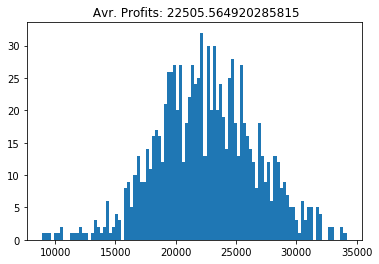

In [ ]:
plt.hist(profits,bins=100)
plt.title(f' Avr. Profits: {(np.mean(profits))}')

In [ ]:
max(profits)

34170.83038805798